In [78]:
# ===============================================
# Video Stutter Detection Notebook
# このノートブックは動画のカクつき（stutter）を検出・解析するための最終段階のコード
# （変更前）実行環境（カーネル）はTestProg_video（Python 3.8.19）で行ってください
# （変更後）実行環境（カーネル）はTSTVIDEO_Prog（Python 3.12.11）で行ってください
#
# ■メモ
# 改善確が終わったら、バージョンアップする。
# 仮想環境で別のVScodeで同じ環境に接続してるとつながらない？
#
# v0.0.3での対応
# フレームの取りこぼしがあるため改善する。
# 動作は止まってないのに5分で止まってしまう。→問題なし。
# 10分毎の画像消去（18000）あたりでキュー詰まりを起こしてる。カクツキ検知、保存ともに。
# ===============================================

In [ ]:
# ==========================================================
# 必要なライブラリのインポート（重複除去・カテゴリ別整理）
# ==========================================================

# --- 画像処理・数値計算 ---
import cv2                   # OpenCV: 動画読み込み・画像処理用
import numpy as np            # NumPy: 数値計算・配列処理用

# --- 可視化 ---
import matplotlib.pyplot as plt  # グラフ描画・可視化用

# --- GUI ---
import tkinter as tk             # GUI用
from tkinter import ttk          # GUI用（拡張ウィジェット）

# --- ファイル・システム操作 ---
import os                        # ファイルパス操作・環境操作
import shutil                    # ファイルコピー・削除
import csv                       # CSVファイル操作

# --- 並行処理 ---
import threading                 # マルチスレッド処理
import queue                     # スレッド間通信・キュー処理

# --- その他ユーティリティ ---
import time                      # 時間計測・待機
from datetime import datetime    # 日付・時刻操作
import gc                        # ガーベジコレクション操作
import re                        # 正規表現処理
import sys                       # システム関連（パス・終了処理など）

import pandas as pd
import matplotlib.pyplot as plt
import cupy as cp

# Windows用
try:
    import win32com.client
    from win32com.client import GetObject
except ImportError:
    win32com = None

# Try import cupy; if unavailable or no GPU, fall back to numpy mode
USE_CUPY = False
try:
    import cupy as cp
    try:
        gpu_count = cp.cuda.runtime.getDeviceCount()
        if gpu_count > 0:
            USE_CUPY = True
        else:
            USE_CUPY = False
    except Exception:
        USE_CUPY = False
except Exception:
    USE_CUPY = False

In [80]:
# -----------------------------------------------
# list_video_devices 関数 (利用可能ビデオキャプチャデバイス一覧取得関数)
# -----------------------------------------------
"""
概要:
    接続されているビデオキャプチャデバイス（Webカメラなど）を探索し、
    利用可能なデバイス番号と識別名のリストを返す関数。
    この関数を使用することで、ユーザーが利用可能なカメラデバイスを選択可能になる。
    
引数:
    max_devices (int, optional): チェックする最大デバイス番号。デフォルトは10。
    timeout (float, optional): 各デバイスを試す際のタイムアウト秒数。デフォルトは1.0秒。
    
戻り値:
    devices (list of tuples): 利用可能なデバイスのリスト。
        例: [(0, 'Camera 0'), (1, 'Camera 1'), ...]
        
注意:
    - デバイスマネージャーで Trifora など特定ドライバを使用している場合、
      一部デバイスが正常に認識されないことがあります。
    - cv2.VideoCapture() は番号順にデバイスを開くため、
      接続順序によってデバイス番号が変わることがあります。
"""
def get_camera_name_from_index(idx):
    """
    WindowsのWMI経由でデバイス名を取得する（DirectShowベース）
    """
    if win32com is None:
        return f"Camera {idx}"

    try:
        wmi = GetObject("winmgmts:")
        devices = wmi.InstancesOf("Win32_PnPEntity")
        for dev in devices:
            if dev.Name and ("Camera" in dev.Name or "Webcam" in dev.Name or "USB" in dev.Name):
                # 対応するデバイス番号は特定困難なので名前のみ返す
                return dev.Name
    except Exception:
        pass

    return f"Camera {idx}"


def list_video_devices(max_devices=10, timeout=1.0):
    devices = []

    def try_open_device(idx, result_dict):
        try:
            cap = cv2.VideoCapture(idx, cv2.CAP_DSHOW)
            if cap.isOpened():
                result_dict["opened"] = True
            cap.release()
        except Exception as e:
            print(f"デバイス {idx} は無視されました: {e}")
            result_dict["opened"] = False

    for idx in range(max_devices):
        result = {"opened": False}
        t = threading.Thread(target=try_open_device, args=(idx, result))
        t.start()
        t.join(timeout=timeout)

        if t.is_alive():
            print(f"デバイス {idx} はタイムアウト ({timeout} 秒) によりスキップされました")
        elif result["opened"]:
            name = get_camera_name_from_index(idx)
            devices.append((idx, name))

    return devices


if __name__ == "__main__":
    print("利用可能なビデオキャプチャデバイス:")
    devices = list_video_devices(max_devices=10, timeout=1.0)
    for idx, name in devices:
        print(f"デバイス番号: {idx}, 名前: {name}")


利用可能なビデオキャプチャデバイス:
デバイス番号: 0, 名前: NVIDIA USB Type-C Port Policy Controller
デバイス番号: 1, 名前: NVIDIA USB Type-C Port Policy Controller


In [81]:
# -----------------------------------------------
# launch_gui 関数 (ビデオデバイス選択GUI関数)
# -----------------------------------------------
"""
概要:
    ユーザーが接続されているビデオキャプチャデバイスの中から
    1つを選択できるシンプルなGUIを表示し、
    選択されたデバイス番号を返す関数。

引数:
    devices (list of tuples):
        list_video_devices() などで取得した利用可能なデバイスのリスト。
        例: [(0, 'Camera 0'), (1, 'Camera 1'), ...]

戻り値:
    int or None:
        - ユーザーが「開始」ボタンを押した場合 → 選択されたデバイス番号を返す
        - GUIを閉じた、または何も選ばなかった場合 → None を返す

注意:
    - combo.current(0) により、デフォルトで最初のデバイスが選択される。
    - GUIを閉じただけで何も選ばなかった場合は None が返る。
    - tkinter は標準ライブラリのため、追加インストールは不要。
"""
def launch_gui(devices):
    selected_device = {"idx": None}  # 辞書で選択結果を共有（クロージャ内で参照できるようにする）

    # --------------------------------------------
    # GUI ウィンドウの基本設定
    # --------------------------------------------
    root = tk.Tk()                     # メインウィンドウ作成
    root.title("デバイス選択")          # ウィンドウタイトル設定
    root.geometry("300x150")           # ウィンドウサイズ（任意）
    root.resizable(False, False)       # サイズ変更を禁止

    # ラベル表示
    tk.Label(root, text="使用するデバイスを選択:").pack(pady=5)

    # --------------------------------------------
    # コンボボックス（デバイス一覧表示）
    # --------------------------------------------
    # 表示用に "Camera 0 (番号: 0)" のような文字列リストを生成
    display_names = [f"{name} (番号: {idx})" for idx, name in devices]

    device_var = tk.StringVar()  # コンボボックスの選択値を保持する変数

    # ttk.Combobox：選択式のプルダウンリスト
    combo = ttk.Combobox(
        root,
        textvariable=device_var,
        values=display_names,
        state="readonly"  # 編集不可（選択のみ）
    )
    combo.current(0)  # デフォルトで最初の項目を選択
    combo.pack(pady=5)

    # --------------------------------------------
    # 「開始」ボタンの動作定義
    # --------------------------------------------
    """
    「開始」ボタン押下時の処理。
    現在選択されている項目のインデックスからデバイス番号を取得し、
    それを共有辞書 selected_device に格納してウィンドウを閉じる。
    """
    def on_start():
        selected_device["idx"] = devices[combo.current()][0]
        root.destroy()  # GUIを閉じる（mainloopを終了）

    # ボタンの作成と配置
    tk.Button(root, text="開始", command=on_start).pack(pady=10)

    # --------------------------------------------
    # GUI メインループ開始（ここで処理が一時停止し、ユーザー操作を待つ）
    # --------------------------------------------
    root.mainloop()

    # 閉じた後、選択されたデバイス番号を返す（選択なしなら None）
    return selected_device["idx"]

In [82]:
# ====================================================
# 🔒 safe_rmtree 関数（安全で完全なフォルダ削除関数 / Windows対応・再試行付き）
# ====================================================
"""
概要:
    指定したフォルダを安全に削除する関数。
    Windows環境でよく発生する「削除中にファイルロックやアクセス拒否で失敗する」ケースにも対応し、
    一定回数リトライを行いながら、フォルダとその中身を完全に削除する。

引数:
    folder_path (str): 削除対象のフォルダパス。
    retry (int, optional): 削除を再試行する回数。デフォルトは3回。
    wait (float, optional): 再試行の間隔（秒）。デフォルトは0.5秒。

動作:
    - 存在しないフォルダを指定した場合はスキップしてメッセージを表示。
    - フォルダ内の全ファイル・サブフォルダを逆順に削除（os.walk(topdown=False)）。
    - 削除進捗をコンソール上にバー表示（例: [##########----------] 50%）。
    - 削除中にエラーが発生した場合でも処理を継続し、最大 retry 回までリトライ。

戻り値:
    なし（処理結果は標準出力にメッセージとして表示）

注意:
    - 削除対象フォルダは **完全に消去** されるため、取り消しはできません。
    - フォルダが他のプロセスによって使用中の場合、一時的に削除が遅れる場合があります。
    - Windows特有の一時ロックを考慮して wait 秒待機後に再試行を行います。
"""
def safe_rmtree(folder_path: str, retry=3, wait=0.5):
    # -------------------------------
    # 存在チェック
    # -------------------------------
    if not os.path.exists(folder_path):
        print(f"🗑️ フォルダ不存在: {folder_path}")
        return

    # -------------------------------
    # 内部関数: フォルダ内の全要素を取得（下位から上位へ削除するため）
    # -------------------------------
    def get_all_entries(path):
        entries = []
        # topdown=False により、ファイル → サブフォルダ → 親フォルダ の順に削除可能
        for root, dirs, files in os.walk(path, topdown=False):
            # ファイルを追加
            entries.extend([os.path.join(root, f) for f in files])
            # ディレクトリを追加
            entries.extend([os.path.join(root, d) for d in dirs])
        return entries

    # -------------------------------
    # 削除処理本体
    # -------------------------------
    for attempt in range(retry):
        try:
            all_entries = get_all_entries(folder_path)
            total = len(all_entries)

            # サブフォルダ・ファイルが空ならフォルダ自体を削除
            if total == 0:
                os.rmdir(folder_path)
                print(f"🗑️ 完全削除済み: {folder_path}")
                return

            # 削除ループ（進捗付き）
            for i, entry in enumerate(all_entries, start=1):
                try:
                    if os.path.isfile(entry) or os.path.islink(entry):
                        os.remove(entry)  # ファイル or シンボリックリンク削除
                    elif os.path.isdir(entry):
                        os.rmdir(entry)   # 空フォルダ削除
                except Exception as e:
                    print(f"⚠ 削除失敗: {entry} → {e}")

                # ----------------------------------------
                # 進捗バー表示
                # ----------------------------------------
                pct = int(i / total * 100)
                bar_len = 30  # バーの長さ（文字数）
                filled = int(bar_len * pct / 100)
                sys.stdout.write(f"\r削除中: [{'#'*filled}{'-'*(bar_len-filled)}] {pct}%")
                sys.stdout.flush()

            # ----------------------------------------
            # 最後にフォルダ自体を削除
            # ----------------------------------------
            try:
                os.rmdir(folder_path)
            except Exception as e:
                print(f"\n⚠ フォルダ自体の削除失敗: {e}")
            else:
                print(f"\n🗑️ 完全削除済み: {folder_path}")
            break  # 成功したらループを抜ける

        except Exception as e:
            print(f"\n⚠ 削除中エラー: {e} → {wait}秒後に再試行 ({attempt+1}/{retry})")
            time.sleep(wait)
    else:
        # retry 回すべて失敗した場合
        print(f"❌ {folder_path} の削除に失敗しました。")


In [ ]:
# ====================================================
# stutter_worker_auto_threshold_csv 関数
# バックグラウンドワーカー付き 逐次自動閾値カクつき検知（CSVログ出力付き）
# バックグラウンドワーカーが逐次フレーム差分＋自動閾値判定＋カクつきフレーム保存＋CSV出力を担当
# ====================================================
# ---------------------------------------------------------
# カクつき検知ワーカー（CuPy優先、なければNumPyでフォールバック）
# - 転送効率とバッチ統計（window）を意識した実装
# ---------------------------------------------------------
"""
概要:
    バックグラウンドでフレームを受け取り、逐次的にカクつき（stutter）を検知するワーカー関数。
    - フレーム間差分（非ゼロ画素数）に基づき自動閾値を算出。
    - 差分が閾値以下の連続フレームを「カクつき」と判定。
    - min_time_diff 未満の短いカクつきは除外。
    - 十分な長さのカクつきフレームは PNG として output_folder に保存。
    - フレーム差分値、閾値、カクつきフラグを threshold_log.csv に逐次記録。

引数:
    frame_queue (queue.Queue): メインスレッドから送られる (frame_index, frame_image) タプルのキュー。
    output_folder (str): カクつきフレーム保存先フォルダパス。存在しない場合は自動作成。
    stop_flag (threading.Event): ワーカー終了を通知するフラグ。
    fps (float, optional): キャプチャFPS。デフォルトは60。
    min_time_diff (float, optional): これ未満の短いカクつきは除外する秒数。デフォルト0.1秒。
    k (float, optional): 自動閾値算出用の係数。デフォルト2.0。

動作:
    - キューからフレームを取得し、グレースケールに変換。
    - 直前フレームとの差分を計算し、非ゼロ画素数を算出。
    - 最近100フレームの差分から平均と標準偏差を計算し、閾値 = 平均 - k*標準偏差 と設定。
    - 差分が閾値以下の場合、カクつきフレーム候補として一時リストに追加。
    - 連続カクつきが min_time_diff 未満の場合は破棄。
    - 十分な長さの連続カクつきの場合、最初のフレームを PNG として保存。
    - CSV に (frame_idx, frame_diff, threshold, stutter_flag) を逐次書き込み。
    - stop_flag が立つか、キューに None が入ると終了。

戻り値:
    なし（処理結果は output_folder 内の PNG と threshold_log.csv に保存）

注意:
    - min_time_diff 未満の短いカクつきは自動的に除外される。
    - CSV と PNG 保存は逐次行われるため、リアルタイム処理に対応。
    - 処理終了時には残った連続カクつきも min_time_diff 以上なら保存。
    - ワーカーはデーモンスレッドとして起動することを想定。
"""

def stutter_worker_auto_threshold_cupy(frame_queue, output_folder, stop_flag,
                                       fps=30, min_time_diff=0.1, k=2.0,
                                       stat_window=100, batch_stat_every=16):
    """
    GPU (CuPy) を使ってフレーム差分と統計を高速化するワーカー。
    - stat_window: 閾値計算に使う最大履歴長（例: 100）
    - batch_stat_every: diff_history をまとめて GPU に渡して統計を取る頻度（回数）
    """
    os.makedirs(output_folder, exist_ok=True)
    log_file = os.path.join(output_folder, "threshold_log.csv")
    with open(log_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["time", "frame_idx", "frame_diff", "threshold", "stutter_flag", "queue_size", "queue_max"])

    prev_gray_gpu = None  # if GPU
    prev_gray_cpu = None  # if CPU fallback
    diff_history = []     # CPU上に差分数を保持（小さい int の列）
    temp_stutter_indices = []
    min_frame_diff = max(1, int(min_time_diff * fps))

    # helpers depending on mode
    use_gpu = USE_CUPY
    if use_gpu:
        print("▶ stutter worker: GPU (CuPy) モードを使用します。")
    else:
        print("▶ stutter worker: CPU (NumPy) モードを使用します。")

    stat_counter = 0  # バッチ統計の頻度制御

    try:
        while not stop_flag.is_set():
            try:
                item = frame_queue.get(timeout=1)
            except queue.Empty:
                continue

            if item is None:
                frame_queue.task_done()
                break

            idx, frame = item
            # CPUでグレースケール変換（ほとんどのカメラSDKはここで取得する）
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            non_zero_count = 0
            threshold = 0.0
            stutter_flag = 0

            if use_gpu:
                # --- GPU転送 (CuPy) ---
                # cp.asarray は内部で最適な転送を行います（環境次第で pinned memory を自動使用する場合あり）
                gray_gpu = cp.asarray(gray)  # dtype:uint8

                if prev_gray_gpu is not None:
                    diff_gpu = cp.abs(gray_gpu.astype(cp.int16) - prev_gray_gpu.astype(cp.int16))
                    # 非ゼロ画素数を GPU 上で計算
                    non_zero_count = int(cp.count_nonzero(diff_gpu).get())

                    # 保存履歴（CPU上）は小さいのでそのまま append（int）
                    diff_history.append(non_zero_count)
                    if len(diff_history) > stat_window:
                        # keep window bounded
                        diff_history.pop(0)

                    # バッチで統計を取る頻度を落として呼び出し回数を減らす（PCIe転送を削減）
                    stat_counter += 1
                    if stat_counter >= batch_stat_every:
                        stat_counter = 0
                        if len(diff_history) >= 2:
                            # まとめて GPU へ転送して mean/std を計算
                            dh_gpu = cp.asarray(diff_history, dtype=cp.float32)
                            mean_v = float(cp.mean(dh_gpu).get())
                            std_v = float(cp.std(dh_gpu).get())
                            threshold = max(mean_v - k * std_v, 0.0)
                            # 明示的に解放（ホストとGPUのメモリ管理を促す）
                            del dh_gpu
                        else:
                            threshold = 0.0

                    # カクつき判定
                    if threshold > 0 and non_zero_count <= threshold:
                        temp_stutter_indices.append((idx, frame))
                        stutter_flag = 1
                    else:
                        if 0 < len(temp_stutter_indices) < min_frame_diff:
                            temp_stutter_indices = []
                        elif len(temp_stutter_indices) >= min_frame_diff:
                            first_idx, first_frame = temp_stutter_indices[0]
                            cv2.imwrite(os.path.join(output_folder, f"stutter_{first_idx:08d}.png"), first_frame)
                            temp_stutter_indices = []
                        stutter_flag = 0

                    # cleanup GPU temporaries to avoidメモリ断片化
                    del diff_gpu

                # keep prev
                prev_gray_gpu = gray_gpu
                # occasionally free pool (頻繁にやると逆効果なのでほどほどに)
                if cp.get_default_memory_pool().used_bytes() > 200 * 1024 * 1024:  # 200MB閾値目安
                    cp.get_default_memory_pool().free_all_blocks()

            else:
                # --- CPU (NumPy) フォールバックパス ---
                if prev_gray_cpu is not None:
                    diff = cv2.absdiff(gray, prev_gray_cpu)
                    non_zero_count = int(np.count_nonzero(diff))
                    diff_history.append(non_zero_count)
                    if len(diff_history) > stat_window:
                        diff_history.pop(0)

                    # 統計（CPU）
                    if len(diff_history) >= 2:
                        mean_v = float(np.mean(diff_history))
                        std_v = float(np.std(diff_history))
                        threshold = max(mean_v - k * std_v, 0.0)
                    else:
                        threshold = 0.0

                    if threshold > 0 and non_zero_count <= threshold:
                        temp_stutter_indices.append((idx, frame))
                        stutter_flag = 1
                    else:
                        if 0 < len(temp_stutter_indices) < min_frame_diff:
                            temp_stutter_indices = []
                        elif len(temp_stutter_indices) >= min_frame_diff:
                            first_idx, first_frame = temp_stutter_indices[0]
                            cv2.imwrite(os.path.join(output_folder, f"stutter_{first_idx:08d}.png"), first_frame)
                            temp_stutter_indices = []
                        stutter_flag = 0

                prev_gray_cpu = gray

            # --- ログ書き込み ---
            with open(log_file, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([
                    datetime.now().strftime("%H:%M:%S.%f")[:-3],
                    idx,
                    non_zero_count,
                    f"{threshold:.3f}",
                    stutter_flag,
                    frame_queue.qsize(),
                    frame_queue.maxsize
                ])

            # finalize this item
            frame_queue.task_done()

            # free some CPU mem references
            del gray, frame

    finally:
        # flush any remaining stutter frames
        if len(temp_stutter_indices) >= min_frame_diff:
            first_idx, first_frame = temp_stutter_indices[0]
            cv2.imwrite(os.path.join(output_folder, f"stutter_{first_idx:08d}.png"), first_frame)
        print("✅ stutter worker 終了")
        gc.collect()
        # GPU側を使っていたらメモリ解放
        if use_gpu:
            try:
                cp.get_default_memory_pool().free_all_blocks()
            except Exception:
                pass


In [84]:
# -------------------------------------------------------
# save_worker 関数
# 非同期保存用ワーカー
# -------------------------------------------------------
"""
概要:
    非同期でフレームを保存するワーカー関数。
    メインスレッドから渡されたキューを監視し、到着したフレームを順次ディスクに保存する。
    キャプチャと保存処理を分離することで、メインスレッドの処理負荷を軽減し、
    プレビュー表示やフレームキューへの送信が滞らないようにする。

引数:
    save_queue (queue.Queue): メインスレッドから渡されるフレーム保存用キュー。
                              各アイテムは (frame_index, frame_image) のタプル。
                              終了時は None をキューに入れてワーカーを停止。
    folder_path (str): 保存先のフォルダパス。存在しない場合は事前に作成しておく必要あり。

動作:
    - 無限ループでキューを取得。
    - キューから None が来たらループを抜けて終了。
    - 各フレームを JPEG 形式で指定フォルダに保存。
    - 保存中に例外が発生しても処理を継続し、エラー内容を標準出力に表示。
    - 保存完了後、task_done() を呼び出してキュー管理を更新。

戻り値:
    なし（処理結果は標準出力にメッセージとして表示）

注意:
    - この関数はデーモンスレッドとして起動することを想定。
    - キューが空の間は待機状態となり、CPU負荷は低い。
    - JPEG保存時の例外処理は簡易的で、必要に応じてリトライやログ出力を追加可能。
"""
def save_worker(save_queue, folder_path, queue_log_file=None):
    """
    キューに渡されたフレームを非同期で保存。
    保存後にキューサイズをログに残す。

    Args:
        save_queue (queue.Queue): 保存対象フレームのキュー
        folder_path (str): 保存先フォルダ
        queue_log_file (str, optional): キュー状態を記録するCSVファイルパス
    """
    # キューログファイルをフォルダ内に作成する場合
    if queue_log_file is None:
        queue_log_file = os.path.join(folder_path, "queue_log.csv")

    # ログCSVのヘッダー作成
    try:
        with open(queue_log_file, "w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(["frame_idx", "queue_size", "queue_max"])
    except Exception as e:
        print(f"⚠ キューログヘッダー作成エラー: {e}")

    while True:
        item = save_queue.get()
        if item is None:
            save_queue.task_done()
            break

        idx, frame = item
        try:
            filename = os.path.join(folder_path, f"frame_{idx:05d}.jpg")
            cv2.imwrite(filename, frame)
        except Exception as e:
            print(f"⚠ フレーム保存エラー: {e}")

        # --- キューサイズログ ---
        try:
            qsize = save_queue.qsize()
            with open(queue_log_file, "a", newline="", encoding="utf-8") as f:
                writer = csv.writer(f)
                writer.writerow([idx, qsize, save_queue.maxsize])
        except Exception as e:
            print(f"⚠ キューログ保存エラー: {e}")

        save_queue.task_done()

In [85]:
class CameraCapture:
    """🎥 スレッドカメラクラス（常に最新フレームを保持）"""
    def __init__(self, device_number=0, width=720, height=480, target_fps=30):
        self.cap = cv2.VideoCapture(device_number, cv2.CAP_DSHOW)
        if not self.cap.isOpened():
            raise RuntimeError("❌ カメラを開けませんでした。")

        # 解像度・FPS設定
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
        self.cap.set(cv2.CAP_PROP_FPS, target_fps)
        self.cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)  # 常に最新フレームに更新

        self.frame = None
        self.lock = threading.Lock()
        self.running = True

        # 別スレッドで常時読み取り
        self.thread = threading.Thread(target=self._update, daemon=True)
        self.thread.start()

        # 初期バッファ安定
        time.sleep(0.2)
        for _ in range(2):
            self.cap.grab()  # self.cap を使用

    def _update(self):
        while self.running:
            ret, frame = self.cap.read()
            if not ret:
                continue
            with self.lock:
                self.frame = frame.copy()

    def read(self):
        with self.lock:
            if self.frame is None:
                return None
            return self.frame.copy()

    def release(self):
        self.running = False
        self.thread.join(timeout=1)  # スレッド終了を待機
        self.cap.release()


In [86]:
# ======================================================
# 🧠 メインキャプチャ＆カクつき検知スレッド統合関数
# ======================================================
def start_capture_and_detect_worker(device_number=0, width=720, height=480,
                                    capture_fps=30, display_fps=10,
                                    min_time_diff=0.1, max_temp_frames=18000,
                                    stop_no_diff_sec=300, k=2.0):

    # --- デスクトップパス準備 ---
    desktop = os.path.join(os.path.expanduser("~"), "Desktop")
    temp_folder = os.path.join(desktop, "temp_frames")
    output_folder = os.path.join(desktop, "stutter_frames")

    for folder in (temp_folder, output_folder):
        if os.path.exists(folder):
            for f in os.listdir(folder):
                try:
                    os.remove(os.path.join(folder, f))
                except:
                    pass
        os.makedirs(folder, exist_ok=True)
    print(f"📁 {temp_folder} と {output_folder} を作成しました。")

    # --- カメラ起動（スレッド化） ---
    try:
        cam = CameraCapture(device_number, width, height, capture_fps)
    except RuntimeError as e:
        print(str(e))
        return 0, output_folder, 0, []

    # --- スレッド起動系 ---
    save_queue = queue.Queue(maxsize=100)
    save_thread = threading.Thread(target=save_worker, args=(save_queue, temp_folder), daemon=True)
    save_thread.start()

    stop_flag = threading.Event()
    frame_queue = queue.Queue(maxsize=10)

    worker = threading.Thread(
        target=stutter_worker_auto_threshold_csv_cupy,  # 既存ワーカーをそのまま使う
        args=(frame_queue, output_folder, stop_flag, capture_fps, min_time_diff, k),
        daemon=True
    )
    worker.start()

    # --- キャプチャループ ---
    frame_count = 0
    start_time = time.time()
    prev_display_time = start_time
    display_interval = 1.0 / display_fps
    interval = 1.0 / capture_fps
    next_capture_time = start_time

    print("🎥 映像キャプチャ開始。'q'キーで終了できます。")

    try:
        while not stop_flag.is_set():
            frame = cam.read()
            if frame is None:
                continue

            frame_count += 1
            frame_copy = frame.copy()

            # --- 非同期保存 ---
            try:
                save_queue.put_nowait((frame_count, frame_copy))
            except queue.Full:
                print("⚠ 保存キュー満杯、スキップ")

            # --- 検知キュー ---
            try:
                frame_queue.put_nowait((frame_count, frame_copy))
            except queue.Full:
                pass

            # --- 表示 ---
            curr_time = time.time()
            if curr_time - prev_display_time >= display_interval:
                fps_disp = 1.0 / (curr_time - prev_display_time)
                prev_display_time = curr_time
                display_frame = frame.copy()
                cv2.putText(display_frame, f"Display FPS: {fps_disp:.2f}",
                            (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                cv2.imshow("Preview", display_frame)
                del display_frame

            # --- FPS間隔調整 ---
            now = time.time()
            if now < next_capture_time:
                time.sleep(next_capture_time - now)
            next_capture_time += interval

            # --- 終了条件 ---
            if cv2.waitKey(1) & 0xFF == ord('q'):
                print("🧍 ユーザー操作による終了")
                stop_flag.set()
                break

            if frame_count % max_temp_frames == 0:
                print(f"🧹 一時フォルダをクリアしました（{max_temp_frames}フレーム到達）")
                for f in os.listdir(temp_folder):
                    try:
                        os.remove(os.path.join(temp_folder, f))
                    except:
                        pass

            if frame_count % 300 == 0:
                gc.collect()

    except KeyboardInterrupt:
        stop_flag.set()

    finally:
        # --- 終了処理 ---
        cv2.destroyAllWindows()
        stop_flag.set()
        frame_queue.put(None)
        worker.join(timeout=5)
        save_queue.put(None)
        save_thread.join()
        cam.release()

        total_time = time.time() - start_time
        actual_fps = frame_count / total_time if total_time > 0 else 0
        stutter_files = [f for f in os.listdir(output_folder) if f.endswith(".png")]

        print(f"✅ 完全終了: {frame_count} フレーム（実測FPS: {actual_fps:.2f}）")
        print(f"💾 カクつきフレームは {output_folder} に保存済み")
        gc.collect()

    return frame_count, output_folder, actual_fps, stutter_files

In [87]:
# ====================================================
# 🔒 plot_stutter_csv 関数
# ====================================================
"""
概要:
    CSVに記録された逐次カクつき検知のログを読み込み、フレーム差分と自動閾値をグラフ表示する関数。
    カクつきフレームは赤い点で可視化され、時間軸に対するフレーム差分と閾値の関係を直感的に確認できる。

引数:
    output_folder (str): threshold_log.csv および stutterフレーム画像が保存されているフォルダパス。
    fps (float, optional): 1秒あたりのフレーム数。デフォルトは60。

動作:
    - 指定フォルダに threshold_log.csv が存在するか確認。
    - CSVを読み込み、フレーム番号を時間（秒）に変換。
    - メイン軸として frame_diff（非ゼロ画素差）をプロット。
    - stutter_flag が1のフレームを赤い点で表示。
    - サブ軸として自動閾値 threshold をオレンジ色の破線でプロット。
    - 左右の縦軸を統一して比較しやすく表示。
    - 凡例は両軸の情報を統合して表示。
    - タイトルと軸ラベルを設定し、レイアウトを調整。

戻り値:
    なし（グラフを表示するのみ）

注意:
    - CSVファイルが存在しない場合は警告を表示して処理を終了。
    - 時間軸はフレーム番号を fps で割ることで算出。
    - カクつきフレームの視覚化は stutter_flag の情報に基づく。
"""

def plot_stutter_csv(output_folder, fps=30):
    log_file = os.path.join(output_folder, "threshold_log.csv")
    if not os.path.exists(log_file):
        print("⚠ threshold_log.csv が存在しません。")
        return

    df = pd.read_csv(log_file)
    times = df['frame_idx'] / fps

    # メイン軸（frame_diff）
    fig, ax1 = plt.subplots(figsize=(14, 5))
    ax1.plot(times, df["frame_diff"], label="Frame difference", color='blue')
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Frame Difference (Non-zero pixels)", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # カクつきフレームを赤点で表示
    stutter_times = times[df["stutter_flag"] == 1]
    stutter_diff = df["frame_diff"][df["stutter_flag"] == 1]
    ax1.scatter(stutter_times, stutter_diff, color='red', label="Stutter frames")

    # サブ軸（threshold）
    ax2 = ax1.twinx()
    ax2.plot(times, df["threshold"], color='orange', linestyle='--', label="Threshold")
    ax2.set_ylabel("Auto Threshold", color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # --- 左右の縦軸の範囲を統一 ---
    ymin, ymax = ax1.get_ylim()
    ax2.set_ylim(ymin, ymax)

    # タイトルと凡例
    fig.suptitle("Realtime Stutter Detection", fontsize=14)

    # 凡例を両軸のラインから統合して表示
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')

    plt.tight_layout()
    plt.show()

選択されたデバイス番号: 0
📁 C:\Users\HP_PC\Desktop\temp_frames と C:\Users\HP_PC\Desktop\stutter_frames を作成しました。
🎥 映像キャプチャ開始。'q'キーで終了できます。
🧍 ユーザー操作による終了
✅ CuPy版ワーカー終了: GPU演算完了
✅ 完全終了: 601 フレーム（実測FPS: 29.85）
💾 カクつきフレームは C:\Users\HP_PC\Desktop\stutter_frames に保存済み


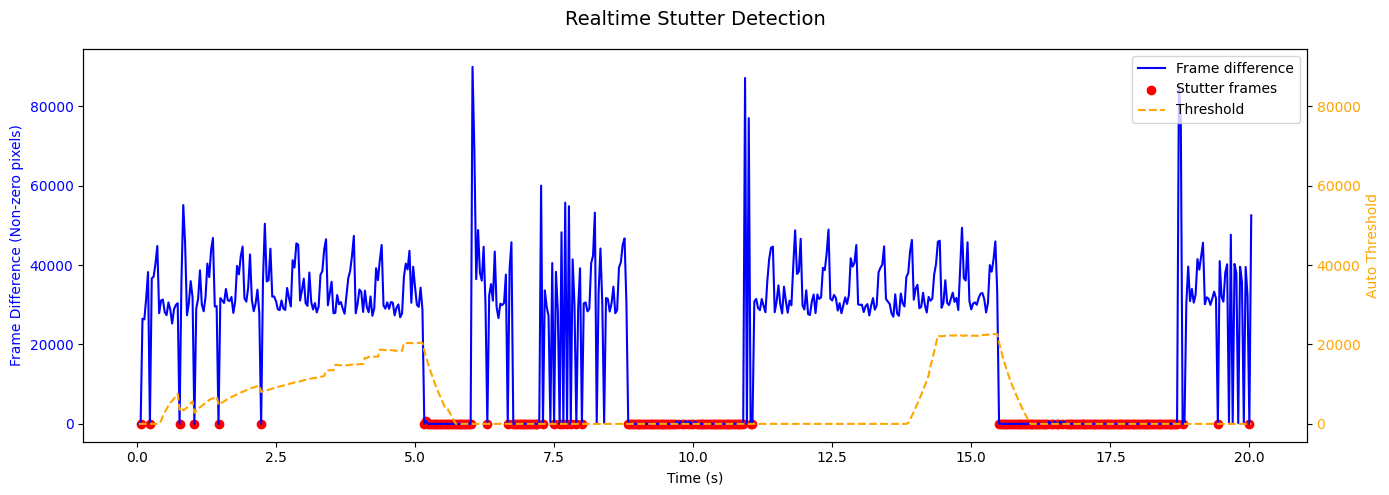

In [88]:
# -----------------------------------------------
# 実行例
# -----------------------------------------------

# Python では、この書き方をすると
# 「このファイルを直接実行したときだけ、以下の処理を動かす」という意味
if __name__ == "__main__":  
    # list_video_devices 関数を呼んで、PCに接続されているカメラを探す
    # 戻り値 devices は [(0, 'Camera 0'), (1, 'Camera 1'), ...] の形式
    devices = list_video_devices()
    if not devices:
        print("利用可能なカメラが見つかりませんでした")
    else:
        # launch_gui 関数で、ユーザーにカメラを選ばせる
        # 戻り値 selected_device は選択されたカメラのデバイス番号
        selected_device = launch_gui(devices)
        if selected_device is not None:
            print(f"選択されたデバイス番号: {selected_device}")
        else:
            print("カメラが選択されませんでした（GUIを閉じました）")

    # 「カメラが選ばれたときだけキャプチャを開始する」 という安全策
    if selected_device is not None: 
        # --- キャプチャ＆逐次カクつき検知実行 ---
        frame_count, output_folder, actual_fps, stutter_files = start_capture_and_detect_worker(
            device_number=selected_device,
            width=720,
            height=480,
            capture_fps=30,
            display_fps=10,
            min_time_diff=0.1,
            max_temp_frames=18000,
            stop_no_diff_sec=300,
            k=2.0
        )

        # CSVログからグラフ化（フレーム画像を読み込む必要なし）
        plot_stutter_csv(output_folder, fps=30)
